

## Steps Followed
    1. Data Processing and Cleaning
    2. Exploratory Data Analysis
    3. Modeling and Testing
    4. ROC and AUC

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import datasets
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
%matplotlib inline


In [20]:
#Loading data into dataframe
bank_data=pd.read_csv('/Users/fatima/Downloads/bank.csv')
bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


# Exploratory Data Analysis 

In [21]:
#Check for null values in data -- There are no null values found
bank_data[bank_data.isnull().any(axis=1)].count()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [22]:
#Describe data
bank_data.describe()


,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [23]:
#Copy data
bank = bank_data.copy()


In [24]:
#Find jobs verses deposit
jobs = ['management','blue-collar','technician','admin.','services','retired','self-employed','student',\
        'unemployed','entrepreneur','housemaid','unknown']

for j in jobs:
    print("{:25} : {:10}". format(j, len(bank[(bank.deposit == "yes") & (bank.job ==j)])))

management                :       1301
blue-collar               :        708
technician                :        840
admin.                    :        631
services                  :        369
retired                   :        516
self-employed             :        187
student                   :        269
unemployed                :        202
entrepreneur              :        123
housemaid                 :        109
unknown                   :         34


In [25]:
#Convert job categories to specific categories
bank['job'] = bank['job'].replace(['management', 'admin.'], 'management')
bank['job'] = bank['job'].replace(['services','housemaid'], 'labour')
bank['job'] = bank['job'].replace(['retired', 'student', 'unemployed', 'unknown'], 'others')

In [26]:
bank.job.value_counts()

management       3900
blue-collar      1944
technician       1823
others           1565
labour           1197
self-employed     405
entrepreneur      328
Name: job, dtype: int64

In [27]:
#Check poutcome count
bank.poutcome.value_counts()

unknown    8326
failure    1228
success    1071
other       537
Name: poutcome, dtype: int64

In [28]:
# Drop 'contact', as every participant has been contacted. 
bank.drop('contact', axis=1, inplace=True)

In [29]:
# Combine 'unknown' and 'other' as 'other' doesnt match with either 'success' or 'failure'
bank['poutcome'] = bank['poutcome'].replace(['other'] , 'unknown')
bank.poutcome.value_counts()

unknown    8863
failure    1228
success    1071
Name: poutcome, dtype: int64

In [30]:
# Change default 'yes/no' to 1/0
bank["default"]
bank['default_cat'] = bank['default'].map( {'yes':1, 'no':0} )
bank.drop('default', axis=1,inplace = True)

In [31]:
# Change housing 'yes/no' to 1/0
bank["housing_cat"]=bank['housing'].map({'yes':1, 'no':0})
bank.drop('housing', axis=1,inplace = True)

In [32]:
# Change loan 'yes/no' to 1/0
bank["loan_cat"] = bank['loan'].map({'yes':1, 'no':0})
bank.drop('loan', axis=1, inplace=True)

In [33]:
# day  : last contact day of the month
# month: last contact month of year
# Drop 'month' and 'day' as they don't give any meaning
bank.drop('month', axis=1, inplace=True)
bank.drop('day', axis=1, inplace=True)

In [34]:
# Change deposit 'yes/no' to 1/0
bank["deposit_cat"] = bank['deposit'].map({'yes':1, 'no':0})
bank.drop('deposit', axis=1, inplace=True)

In [35]:
# pdays: number of days that passed by after the client was last contacted from a previous campaign
#       -1 means client was not previously contacted

print("Customers that have not been contacted before:", len(bank_data[bank_data.pdays==-1]))
print("Max values on pdays    :", bank_data['pdays'].max())

Customers that have not been contacted before: 8324
Max values on pdays    : 854


In [36]:
#Poutcome refers to previous outcome of the marketing campaign and it has three valid outcome either Success, Failure and Non Existent as per the dataset provided by UCI. 
#Unknown is not one of the categories which is widely present in the dataset and adds no value to sample.
#Drop pdays

bank.drop('pdays', axis=1, inplace = True)


In [37]:
bank.tail()


,age,job,marital,education,balance,duration,campaign,previous,poutcome,default_cat,housing_cat,loan_cat,deposit_cat
11157,33,blue-collar,single,primary,1,257,1,0,unknown,0,1,0,0
11158,39,labour,married,secondary,733,83,4,0,unknown,0,0,0,0
11159,32,technician,single,secondary,29,156,2,0,unknown,0,0,0,0
11160,43,technician,married,secondary,0,9,2,5,failure,0,0,1,0
11161,34,technician,married,secondary,0,628,1,0,unknown,0,0,0,0


In [38]:
# Convert categorical variables to dummies
bank_categorical = pd.get_dummies(data=bank, columns = ['job', 'marital', 'education', 'poutcome'], \
                                   prefix = ['job', 'marital', 'education', 'poutcome'])
bank_categorical.head()

,age,balance,duration,campaign,previous,default_cat,housing_cat,loan_cat,deposit_cat,job_blue-collar,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_success,poutcome_unknown
0,59,2343,1042,1,0,0,1,0,1,0,...,0,1,0,0,1,0,0,0,0,1
1,56,45,1467,1,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,1
2,41,1270,1389,1,0,0,1,0,1,0,...,0,1,0,0,1,0,0,0,0,1
3,55,2476,579,1,0,0,1,0,1,0,...,0,1,0,0,1,0,0,0,0,1
4,54,184,673,2,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1


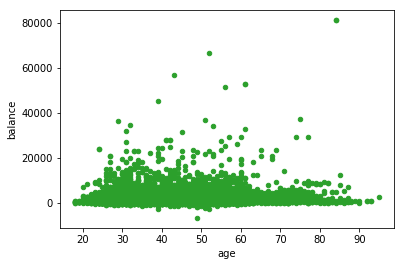

In [39]:
# Across all ages, majority of people have savings of less than 20000.
bank_categorical.plot(kind='scatter', x='age', y='balance', color='C2');

In [40]:
# People who sign up to a term deposit
bank_categorical[bank.deposit_cat == 1].describe()

,age,balance,duration,campaign,previous,default_cat,housing_cat,loan_cat,deposit_cat,job_blue-collar,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_success,poutcome_unknown
count,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.0,5289.000000,...,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000
mean,41.670070,1804.267915,537.294574,2.141047,1.170354,0.009832,0.365854,0.091511,1.0,0.133863,...,0.117603,0.520892,0.361505,0.111741,0.463226,0.377387,0.047646,0.116846,0.184912,0.698242
std,13.497781,3501.104777,392.525262,1.921826,2.553272,0.098676,0.481714,0.288361,0.0,0.340537,...,0.322167,0.499611,0.480482,0.315078,0.498693,0.484779,0.213036,0.321267,0.388263,0.459064
min,18.000000,-3058.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,210.000000,244.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,733.000000,426.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,50.000000,2159.000000,725.000000,3.000000,1.000000,0.000000,1.000000,0.000000,1.0,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,95.000000,81204.000000,3881.000000,32.000000,58.000000,1.000000,1.000000,1.000000,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
# People who signed up to a term deposit having a personal loan and housing loan
len(bank_categorical[(bank_categorical.deposit_cat == 1) & (bank_categorical.loan_cat) & (bank_categorical.housing_cat)])

265

In [42]:
# People who signed up to a term deposit with a credit default 
len(bank_categorical[(bank_categorical.deposit_cat == 1) & (bank_categorical.default_cat ==1)])

52

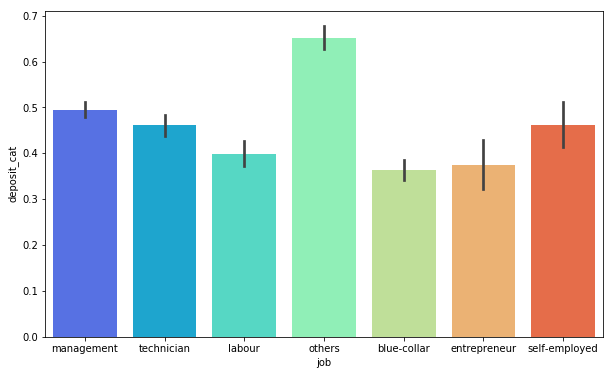

In [43]:
#Job Vs deposit
plt.figure(figsize = (10,6))
sns.barplot(x='job', y = 'deposit_cat', data = bank, hue_order=2, palette='rainbow')

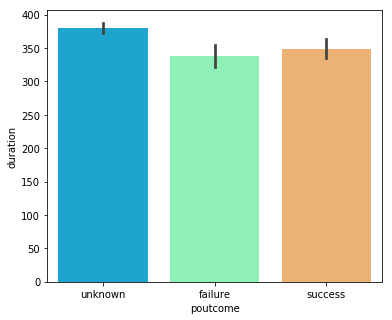

In [44]:
# "previous outcome" Vs "call duration" bar chart

plt.figure(figsize = (6,5))
sns.barplot(x='poutcome', y = 'duration', data = bank,  palette='rainbow')

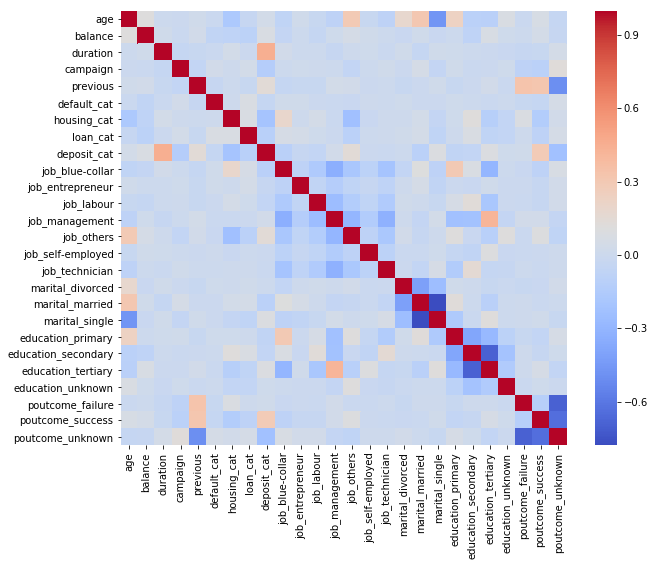

In [45]:
bank_classifier = bank_categorical
# Find Correltion matrix
corr = bank_classifier.corr()
plt.figure(figsize = (10,8))
sns.heatmap(corr, cmap='coolwarm')

In [46]:
# Extract the deposte_cat column (the dependent variable)
deposit_correlation = pd.DataFrame(corr['deposit_cat'].drop('deposit_cat'))
deposit_correlation.sort_values(by = 'deposit_cat', ascending = False)

,deposit_cat
duration,0.451919
poutcome_success,0.286642
job_others,0.144408
previous,0.139867
marital_single,0.094632
education_tertiary,0.094598
balance,0.081129
age,0.034901
job_management,0.031621
poutcome_failure,0.020714


# Modelling
# Apply classifier

In [47]:
# Train-Test split: 20% test data
data_drop_deposit = bank_classifier.drop('deposit_cat', 1)
label = bank_classifier.deposit_cat
data_train, data_test, label_train, label_test = train_test_split(data_drop_deposit, label, test_size = 0.2, random_state = 50)

In [48]:
# Decision tree with depth = 2
dt2 = tree.DecisionTreeClassifier(random_state=1, max_depth=2)
dt2.fit(data_train, label_train)
dt2_score_train = dt2.score(data_train, label_train)
print("Training score: ",dt2_score_train)
dt2_score_test = dt2.score(data_test, label_test)
print("Testing score: ",dt2_score_test)

Training score:  0.7285250307985217
Testing score:  0.7268248992386923


In [49]:
# Decision tree with depth = 4
dt4 = tree.DecisionTreeClassifier(random_state=1, max_depth=4)
dt4.fit(data_train, label_train)
dt4_score_train = dt4.score(data_train, label_train)
print("Training score: ",dt4_score_train)
dt4_score_test = dt4.score(data_test, label_test)
print("Testing score: ",dt4_score_test)

Training score:  0.7867622354127002
Testing score:  0.7733990147783252


In [50]:
# Decision tree with depth = 6
dt6 = tree.DecisionTreeClassifier(random_state=1, max_depth=6)
dt6.fit(data_train, label_train)
dt6_score_train = dt6.score(data_train, label_train)
print("Training score: ",dt6_score_train)
dt6_score_test = dt6.score(data_test, label_test)
print("Testing score: ",dt6_score_test)

Training score:  0.8044573860454698
Testing score:  0.7787729511867443


In [51]:
# Decision tree: To the full depth
dt1 = tree.DecisionTreeClassifier()
dt1.fit(data_train, label_train)
dt1_score_train = dt1.score(data_train, label_train)
print("Training score: ", dt1_score_train)
dt1_score_test = dt1.score(data_test, label_test)
print("Testing score: ", dt1_score_test)

Training score:  1.0
Testing score:  0.7344379758172862


In [52]:
# Create a feature vector
features = data_drop_deposit.columns.tolist()

features


['age',
 'balance',
 'duration',
 'campaign',
 'previous',
 'default_cat',
 'housing_cat',
 'loan_cat',
 'job_blue-collar',
 'job_entrepreneur',
 'job_labour',
 'job_management',
 'job_others',
 'job_self-employed',
 'job_technician',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'poutcome_failure',
 'poutcome_success',
 'poutcome_unknown']

In [53]:
# Find most important features with depth =2

dt2 = tree.DecisionTreeClassifier(random_state=1, max_depth=2)

# Fit the decision tree classifier
dt2.fit(data_train, label_train)

fi = dt2.feature_importances_

l = len(features)
for i in range(0,len(features)):
    print('{:.<20} {:3}'.format(features[i],fi[i]))

age................. 0.0
balance............. 0.0
duration............ 0.849306123902405
campaign............ 0.0
previous............ 0.0
default_cat......... 0.0
housing_cat......... 0.0
loan_cat............ 0.0
job_blue-collar..... 0.0
job_entrepreneur.... 0.0
job_labour.......... 0.0
job_management...... 0.0
job_others.......... 0.0
job_self-employed... 0.0
job_technician...... 0.0
marital_divorced.... 0.0
marital_married..... 0.0
marital_single...... 0.0
education_primary... 0.0
education_secondary. 0.0
education_tertiary.. 0.0
education_unknown... 0.0
poutcome_failure.... 0.0
poutcome_success.... 0.15069387609759496
poutcome_unknown.... 0.0


In [54]:
# According to feature importance results, most important feature is "Duration"
# Let's calculte statistics on Duration
print("Mean duration: {} \nMaximum duration: {}  \nMinimum duration: {} ".format(data_drop_deposit.duration.mean(),data_drop_deposit.duration.max(),data_drop_deposit.duration.min()))

Mean duration: 371.99381831213043 
Maximum duration: 3881  
Minimum duration: 2 


In [55]:
# Make predictions on the test set
predictions = dt2.predict(data_test)

# Calculate accuracy


print("\nAccuracy score: \n{}".format(metrics.accuracy_score(label_test, predictions)))

# Make predictions on the test set using predict_proba
probability = dt2.predict_proba(data_test)[:,1]

# Calculate the AUC metric
print("\nArea Under Curve: \n{}".format(metrics.roc_auc_score(label_test, probability)))


Accuracy score: 
0.7268248992386923

Area Under Curve: 
0.7880265888143609


In [56]:
#Draw ROC Curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

false_positive_rate, true_positive_rate, thresholds = roc_curve(label_test, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

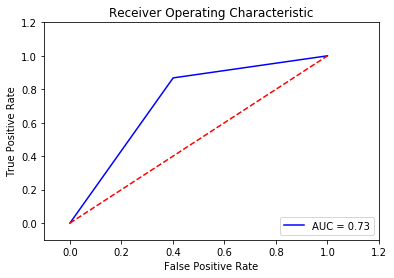

In [57]:
#ROC Curve
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()